In [0]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import io
from IPython.display import Image
import pathlib
from tensorflow.keras import applications as ap
import re
import seaborn as sns
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import datetime

In [0]:
# enable accelerated linear algebra
tf.config.optimizer.set_jit(True)
# enable tensorflow AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Load the TensorBoard notebook extension for training metrics graphs
%load_ext tensorboard


# Use small batches to allow current batch to fit in GPU memory for faster training
BATCH_SIZE = 4  
# Resizing the dataset images
IMAGE_SIDE = 150  
# Shuffling the images to ensure a better fit
SHUFFLE_SIZE = 25  
EPOCHS = 20  

# ensure we are in the correct working directory
os.chdir("/content")

# Local path to the dataset
DATASET_PATH = "/content/Pneumonia-detection-in-Chest-X-Ray-image-with-Deep-Learning/dataset"


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Download the dataset**

In [0]:
!git clone -b dataset https://github.com/etnikg/Pneumonia-detection-in-Chest-X-Ray-image-with-Deep-Learning.git 

fatal: destination path 'Pneumonia-detection-in-Chest-X-Ray-image-with-Deep-Learning' already exists and is not an empty directory.


In [0]:
# Download a local copy of the dataset and then build paths 
# to the different dataset subsets: 'train', 'test', and 'validate'

dataset = pathlib.Path(DATASET_PATH)
test = dataset.joinpath("test")
test_count = len(list(test.glob('**/*.jpeg')))
train = dataset.joinpath("train")
train_count = len(list(train.glob('**/*.jpeg')))
validate = dataset.joinpath("validate")
validate_count = len(list(validate.glob('**/*.jpeg')))


**Preprocess the images in each directory before training**

In [0]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2, 
    shear_range=0.2,
    fill_mode='nearest')


In [0]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=str(train), 
    shuffle=True, 
    target_size=(IMAGE_SIDE, IMAGE_SIDE),
    class_mode='categorical')

Found 3747 images belonging to 2 classes.


In [0]:
test_image_generator = ImageDataGenerator(rescale=1./255)
 

In [0]:
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=str(test), 
    target_size=(IMAGE_SIDE, IMAGE_SIDE),
    shuffle=True, 
    class_mode='categorical')

Found 1172 images belonging to 2 classes.


In [0]:
validate_image_generator = ImageDataGenerator(rescale=1./255)


In [0]:
validate_data_gen = validate_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=str(validate), 
    target_size=(IMAGE_SIDE, IMAGE_SIDE),
    class_mode='categorical',
    shuffle=True)

Found 937 images belonging to 2 classes.


**Create the prediction model**

In [0]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', 
            input_shape=(IMAGE_SIDE, IMAGE_SIDE, 3)),
    Conv2D(16, (5,5), padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32,(3,3), padding='same', activation='relu'),
    Conv2D(32,(3,3),padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64,(3,3), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(96, (3,3),dilation_rate=(2, 2), padding='same', activation='relu'),
    Conv2D(96, (3,3),padding='valid', activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3),dilation_rate=(2, 2), padding='same', activation='relu'),
    Conv2D(128, (3,3),padding='valid', activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(300, activation='relu'),
    Dropout(0.15),
    Dense(2, activation='softmax')
])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 148, 148, 16)      6416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 74, 74, 32)        4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 74, 74, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 64)       

In [0]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy']) 


In [0]:
## some necessary function to simplify files count and visualization via bar plot

def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts

def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)


def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)

def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

**Dataset is divided in relation 80:20 for training/testing images**

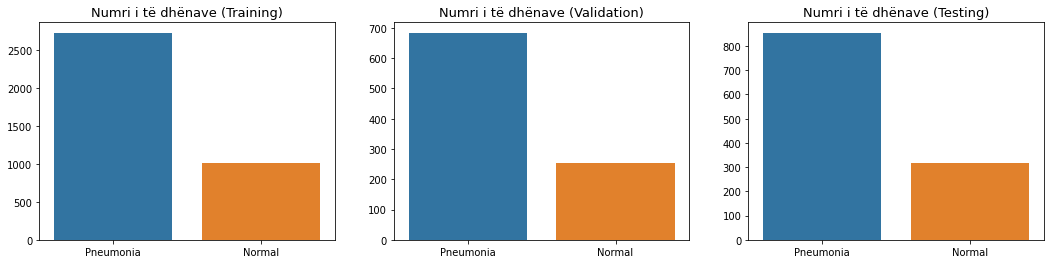

In [0]:

plot_params = {}
plot_params['figsize'] = (18,4)
plot_params["title"] = ""
plot_params["xlabel"] = ""
plot_params["ylabel"] = ""
plot_params["legends"] = []

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10
plot_params["axes.titlesize"] = "small"
plot_params["image_file_name"] = ""

plot_params['title'] = "Numri i të dhënave"
plot_params["save"] = False
plot_params["update_image"] = True

plot_params['subplot'] = 131


plt.figure(figsize=plot_params['figsize'])

title = plot_params['title']
plot_params['title'] = title + " (Training)"
subplot_no = plot_params['subplot'] 



count_bar_plot(train, plot_params)

plot_params['title'] = title + " (Validation)"
plot_params['subplot'] = subplot_no+1
count_bar_plot(validate, plot_params)


plot_params['title'] = title + " (Testing)"
plot_params['subplot'] = subplot_no + 2
count_bar_plot(test, plot_params)

plt.show()
classes = os.listdir(train)
classes = [name_correct(i) for i in classes]

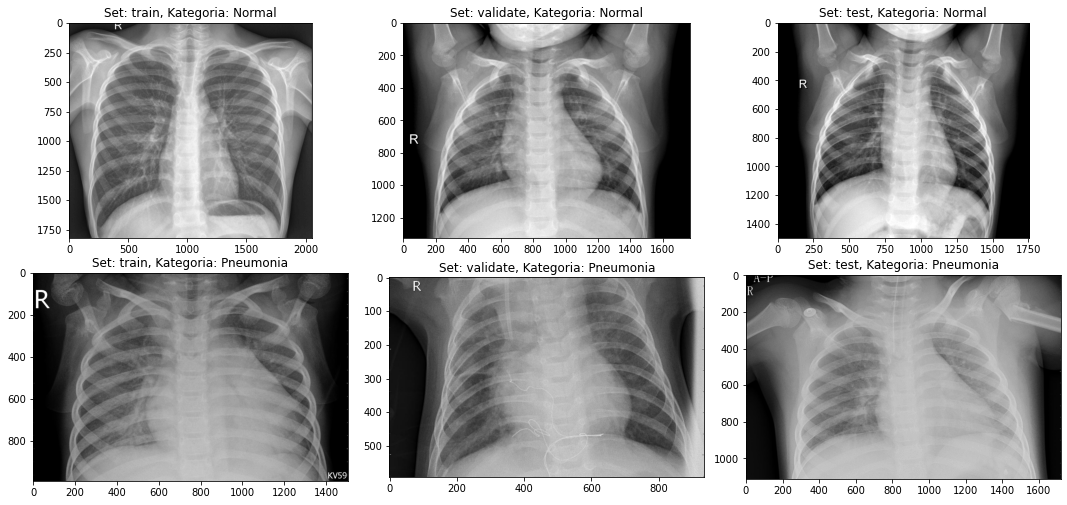

In [0]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'validate', 'test']):
    set_path = DATASET_PATH+'/'+_set
    ax[i].imshow(plt.imread('/'+set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Kategoria: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Kategoria: Pneumonia'.format(_set))

In [0]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Start training the model

In [0]:
history = model.fit(
      train_data_gen,        
      steps_per_epoch=train_count // BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=validate_data_gen,        
      validation_steps=validate_count // BATCH_SIZE,
      callbacks=[tensorboard_callback],
      use_multiprocessing=False,
) 

Epoch 1/20
936/936 [==============================] - 234s 250ms/step - loss: 0.5887 - accuracy: 0.7278 - val_loss: 0.5722 - val_accuracy: 0.7297
Epoch 2/20
936/936 [==============================] - 230s 246ms/step - loss: 0.5037 - accuracy: 0.7545 - val_loss: 0.3128 - val_accuracy: 0.8771
Epoch 3/20
936/936 [==============================] - 234s 249ms/step - loss: 0.3752 - accuracy: 0.8362 - val_loss: 0.2680 - val_accuracy: 0.8953
Epoch 4/20
936/936 [==============================] - 232s 248ms/step - loss: 0.3139 - accuracy: 0.8656 - val_loss: 0.2737 - val_accuracy: 0.8868
Epoch 5/20
936/936 [==============================] - 232s 247ms/step - loss: 0.2780 - accuracy: 0.8838 - val_loss: 0.2447 - val_accuracy: 0.9006
Epoch 6/20
936/936 [==============================] - 236s 253ms/step - loss: 0.2550 - accuracy: 0.9006 - val_loss: 0.1934 - val_accuracy: 0.9199
Epoch 7/20
936/936 [==============================] - 233s 249ms/step - loss: 0.2269 - accuracy: 0.9124 - val_loss: 0.2018 -

Save weights in a .h5 file

In [0]:

TMP_PATH = '/tmp/pneumonia_detection_model.h5'
model.save(TMP_PATH, overwrite=True, include_optimizer=True, save_format='h5')


Preparing model for browser download.  Please wait as it could take a while . . . .


In [0]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Visualize accuracy and loss graph over epochs

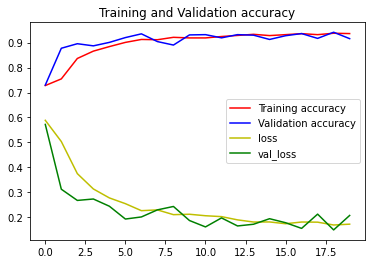

<Figure size 432x288 with 0 Axes>

In [0]:

acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validation accuracy')
plt.plot(epochs,loss,'y',label='loss')
plt.plot(epochs,val_loss,'g',label='val_loss')

plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Evaluate model by tests images

In [0]:
print("results")
result  = model.evaluate_generator(test_data_gen, steps=len(test_data_gen), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
Instructions for updating:
Please use Model.evaluate, which supports generators.
293/293 [==============================] - 21s 72ms/step - loss: 0.1997 - accuracy: 0.9198
Loss     : 0.20  
Accuracy : 91.98%


In [0]:
print("results")
y_pred = model.predict_generator(test_data_gen, steps=len(test_data_gen), verbose=1)  



results
Instructions for updating:
Please use Model.predict, which supports generators.
293/293 [==============================] - 20s 70ms/step
